In [2]:
using RxInfer, Plots, StableRNGs, Distributions, ExponentialFamily
import ExponentialFamily: softmax 

In [284]:
function generate_multinomial_data(rng=StableRNG(123);N = 3, k=3, nsamples = 1000)
    Ψ = randn(rng, k)
    p = softmax(Ψ)
    X = rand(rng, Multinomial(N, p), nsamples)
    X= [X[:,i] for i in 1:size(X,2)];
    return X, Ψ,p
end


generate_multinomial_data (generic function with 2 methods)

In [285]:
nsamples = 5000
X, Ψ, p = generate_multinomial_data(nsamples=nsamples);

In [286]:
@model function multinomial_model(obs, N, ξ_ψ, W_ψ)
    ψ ~ MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ)
    obs .~ MultinomialPolya(N, ψ) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(ξ_ψ, W_ψ))}
end

In [287]:
N = 6
result = infer(
    model = multinomial_model(ξ_ψ=zeros(2), W_ψ=rand(Wishart(3, diageye(2))), N=N),
    data = (obs=X, ),
    iterations = 20,
    free_energy = true,
    showprogress = true,
    options = (
        limit_stack_depth = 100,
    )
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Inference results:
  Posteriors       | available for (ψ)
  Free Energy:     | Real[15645.7, 14601.3, 14054.9, 13833.2, 13747.4, 13714.7, 13702.3, 13697.6, 13695.8, 13695.2, 13694.9, 13694.8, 13694.8, 13694.8, 13694.8, 13694.8, 13694.8, 13694.8, 13694.8, 13694.8]


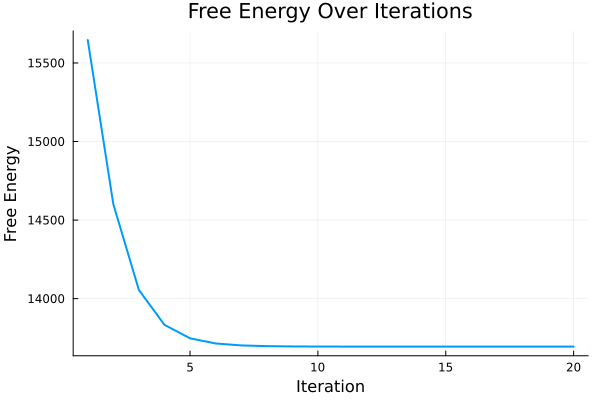

In [288]:
plot(result.free_energy, 
     title="Free Energy Over Iterations",
     xlabel="Iteration",
     ylabel="Free Energy",
     linewidth=2,
     legend=false,
     grid=true,
     )

In [289]:
predictive = @call_rule MultinomialPolya(:x, Marginalisation) (q_N = PointMass(N), q_ψ = result.posteriors[:ψ][end])

Multinomial{Float64, Vector{Float64}}(n=6, p=[0.14572846411266172, 0.30973987232166733, 0.544531663565671])

In [290]:
mse = mean((predictive.p - p).^2);
println("predictive MSE: $mse")

predictive MSE: 0.10798606392658751


In [291]:
@model function multinomial_regression(obs, N, X, ϕ, ξβ, Wβ)
    β ~ MvNormalWeightedMeanPrecision(ξβ, Wβ)
    for i in eachindex(obs)
        Ψ[i] := ϕ(X[i])*β
        obs[i] ~ MultinomialPolya(N, Ψ[i]) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalWeightedMeanPrecision(zeros(length(obs[i])-1), diageye(length(obs[i])-1)))}
    end
end


In [292]:
function generate_regression_data(rng=StableRNG(123);ϕ = identity,N = 3, k=5, nsamples = 1000)
    β = randn(rng, k)
    X = randn(rng, nsamples, k, k)
    X = [X[i,:,:] for i in 1:size(X,1)];
    Ψ = ϕ.(X)
    p = map(x -> logistic_stick_breaking(x*β), Ψ)
    return map(x -> rand(rng, Multinomial(N, x)), p), X, β, p
end


generate_regression_data (generic function with 2 methods)

In [293]:
ϕ = x -> sin(x)
obs, X, β, p = generate_regression_data(;nsamples = 5000, ϕ = ϕ)

([[2, 0, 1, 0, 0, 0], [0, 0, 0, 2, 1, 0], [1, 2, 0, 0, 0, 0], [0, 1, 2, 0, 0, 0], [3, 0, 0, 0, 0, 0], [0, 2, 0, 1, 0, 0], [0, 3, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 1], [2, 0, 1, 0, 0, 0]  …  [0, 3, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0], [0, 3, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0], [0, 1, 2, 0, 0, 0], [0, 2, 0, 0, 1, 0], [2, 1, 0, 0, 0, 0], [0, 2, 0, 0, 0, 1], [1, 1, 1, 0, 0, 0], [0, 3, 0, 0, 0, 0]], [[0.9778851629663716 -0.44829721489865604 … 1.1004093993845896 -1.5158010579554928; 0.14543338516835466 0.12553564655842447 … 0.4798720248684907 -1.4387072190516925; … ; 0.4891142200332808 -1.4491299993450362 … -0.12877636536493103 0.5705828848674638; -2.767308785090824 -0.39855070025600003 … 0.6764954483654967 -0.4465831233253421], [-0.6706626942960996 -0.8534035500965671 … 1.8383741441445682 0.320122742147904; -0.9639856001175278 0.7962638447658941 … 0.17878336369377684 2.117743098414364; … ; -0.19705461445733935 -0.1918011004602745 … -0.4637375923622511 1.024947724209886; -0.164833830

In [294]:
reg_results = infer(  
    model = multinomial_regression(N = 3, ϕ = ϕ, ξβ = zeros(5), Wβ = rand(Wishart(5, diageye(5)))),
    data = (obs=obs,X = X ),
    iterations = 25,
    free_energy = true,
    showprogress = true,
    returnvars = KeepLast(),
    options = (
        limit_stack_depth = 100,
    ) 
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Inference results:
  Posteriors       | available for (Ψ, β)
  Free Energy:     | Real[2778.92, -3353.85, -7621.66, -10131.5, -11527.0, -12284.4, -12690.7, -12907.4, -13022.7, -13083.8  …  -13151.4, -13152.1, -13152.5, -13152.7, -13152.8, -13152.8, -13152.9, -13152.9, -13152.9, -13152.9]


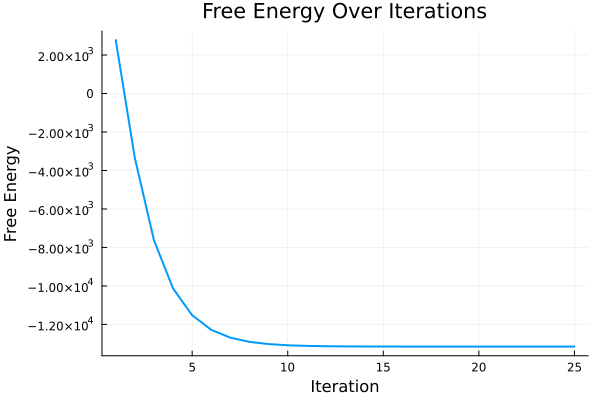

In [295]:
plot(reg_results.free_energy,
title="Free Energy Over Iterations",
xlabel="Iteration",
ylabel="Free Energy",
linewidth=2,
legend=false,
grid=true,)

In [296]:
mse_β =  mean((mean(reg_results.posteriors[:β]) - β).^2)
println("MSE of β estimate: $mse_β")

MSE of β estimate: 9.039952222668923e-5


In [297]:
using LinearAlgebra
using Distributions

# Define the RSLDS model
function rslds_model(n_states, n_latent, n_obs)
    # Parameters for discrete state switching
    W = randn(n_states, n_latent)  # Weight matrix for logistic regression
    b = randn(n_states)            # Bias term
    
    # Parameters for continuous latent state
    A = [0.01randn(n_latent, n_latent) for _ in 1:n_states+1]  # State-dependent transition matrices
    B = [0.2randn(n_latent) for _ in 1:n_states+1]         # Input matrices
    Q = [Matrix(Diagonal(abs.(randn(n_latent)))) for _ in 1:n_states+1]  # Process noise covariances
    
    # Parameters for observations
    C = randn(n_obs, n_latent)     # Observation matrix
    R = Matrix(Diagonal(abs.(randn(n_obs))))  # Observation noise covariance
    
    return W, b, A, B, Q, C, R
end

# Generate data from RSLDS
function generate_rslds_data(W, b, A, B, Q, C, R, T)
    n_states = size(W, 1)
    n_latent = size(W, 2)
    n_obs = size(C, 1)
    
    # Initialize arrays
    s = zeros(Int, T)      # Discrete states
    x = zeros(n_latent, T) # Latent states
    y = zeros(n_obs, T)    # Observations
    
    # Initial state
    s[1] = 1
    x[:, 1] = randn(n_latent)
    
    # Generate sequence
    for t in 2:T
        # Discrete state switching
        logits = W * x[:, t-1] + b
        p[t] = logistic_stick_breaking(logits)
        s[t] = rand(Categorical(p[t]))
        
        μ = A[s[t]] * x[:, t-1] + B[s[t]]
        μ = vec(μ)
        x[:, t] = rand(MvNormalMeanCovariance(μ, Q[s[t]]))
        
        # Generate observation
        y[:, t] = rand(MvNormalMeanCovariance(C * x[:, t], R))
    end
    
    return s, x, y
end

n_states = 3
n_latent = 3
n_obs = 3
T = 300

W, b, A, B, Q, C, R = rslds_model(n_states, n_latent, n_obs)

states, latents, observations = generate_rslds_data(W, b, A, B, Q, C, R, T)
observations = [observations[:, t] for t in 1:T]


300-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [2.6915836563824684, 0.18434810776362898, -1.1321023593780557]
 [-2.3247052042223384, 6.005562861254711, 1.6617723569805145]
 [1.3614198751334237, -0.18002982323792638, -1.283094990588503]
 [-0.13065535536989203, -1.2010282976687752, -0.6939317115063389]
 [2.85459838802701, 0.4673126363789461, -1.5817483236599343]
 [-0.38374684668847747, 0.6599665799066812, 0.0009572165974726932]
 [-0.20441210019009956, -1.152153273988663, 0.603650966091378]
 [3.4695525004529544, -1.3859540482305162, -1.0300744829789559]
 [2.579540234526481, -2.3449169993409527, -0.27120494983579635]
 ⋮
 [2.5947242797636285, -0.7994267397826149, -0.34956538606499243]
 [1.9794893103380833, 2.6707296739869615, 0.8362600968908653]
 [0.8032105762228259, -2.953182194886278, -1.4584600854293812]
 [3.2424191768354147, -2.166363084623457, -1.0274497236750144]
 [-1.0045814772660746, 1.3944922759875216, 1.1636397400869019]
 [-2.161243550566836, 0.5271406749019326, -0.7856484

In [298]:
states

300-element Vector{Int64}:
 1
 1
 1
 3
 2
 1
 2
 2
 1
 1
 ⋮
 2
 2
 1
 1
 1
 3
 1
 1
 1

In [260]:
function BayesBase.prod(::GenericProd, left::Categorical, right::Multinomial)
    @assert right.n == 1
    right_cat = Categorical(right.p)

    p = prod(GenericProd(), left, right_cat).p 
    return Multinomial(1, p)


end

BayesBase.prod(::GenericProd, left::Multinomial, right::Categorical) = prod(GenericProd(), right, left)


In [261]:
@model function rslds_model(obs, n_states, n_latent, W, b, ϕ, A, B, Q, C, R)
    local m, Λ
    x[1] ~ MvNormalWeightedMeanPrecision(zeros(n_latent), diageye(n_latent))
    for t in eachindex(obs)
        s[t] ~  MultinomialPolya(1, W * x[t] + b) where {dependencies = RequireMessageFunctionalDependencies(ψ = MvNormalMeanCovariance(zeros(n_states), diageye(n_states)))}
        for k in 1:n_states+1
            m[t ,k] := A[k] * x[t] + B[k]
            Λ[t, k] ~ Wishart(n_latent+1, diageye(n_latent))
        end
        x[t+1] ~ NormalMixture(switch = s[t], m = m[t, :], p = Λ[t, :])
        obs[t] ~ MvNormalMeanCovariance(C * x[t+1], R)
    end
end


In [281]:
logistic_stick_breaking(randn(8)) 

9-element Vector{Float64}:
 0.5761567407177992
 0.03054081995032119
 0.2734706319552459
 0.03532636721681485
 0.05032071025951613
 0.016983394680118703
 0.0030499037162533154
 0.01163284467223779
 0.0025185868316929733

In [262]:
mean(Multinomial(1, [0.1, 0.8, 0.05, 0.05]))

4-element Vector{Float64}:
 0.1
 0.8
 0.05
 0.05

In [263]:
constraints = @constraints  begin
   q(x, m, s, Λ) = q(x)q(m)q(s)q(Λ)
   q(m) = MeanField()
   q(Λ) = MeanField()
end

init = @initialization begin
    q(x) = MvNormalWeightedMeanPrecision(zeros(n_latent), diageye(n_latent))
    q(s) = Multinomial(1, ones(n_states+1)/(n_states+1))
    q(m) = MvNormalWeightedMeanPrecision(zeros(n_latent), diageye(n_latent))
    q(Λ) = Wishart(n_latent+1, diageye(n_latent))
end

ExponentialFamily.probvec(d::Multinomial) = d.p

In [271]:
reg_results = infer(  
    model = rslds_model(n_states = n_states, n_latent=n_latent, W = W, b = b, ϕ = identity, A = A, B = B, Q = Q, C = C, R = R),
    data = (obs=observations, ),
    iterations = 5,
    free_energy = true,
    showprogress = true,
    constraints = constraints,
    initialization = init,
    returnvars = KeepLast(),
    options = (
        limit_stack_depth = 100,
    ) 
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Inference results:
  Posteriors       | available for (m, s, Λ, x)
  Free Energy:     | Real[2390.09, 1905.31, 1863.15, 1862.05, 1864.06]


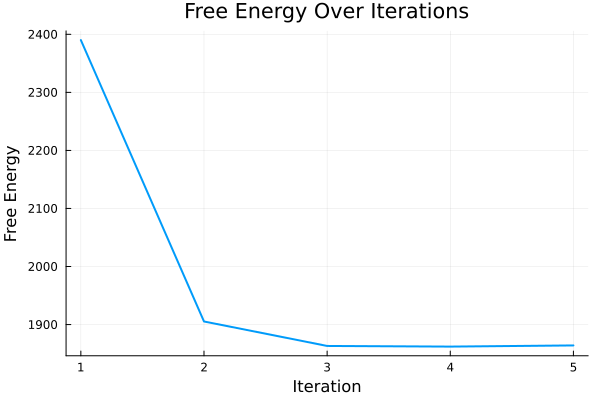

In [272]:
plot(reg_results.free_energy, title="Free Energy Over Iterations", xlabel="Iteration", ylabel="Free Energy", linewidth=2, legend=false, grid=true,)

In [274]:
reg_results.posteriors[:s]

300-element Vector{Multinomial{Float64, Vector{Float64}}}:
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.7982111930457497, 0.1188134053546903, 0.029611886511717513, 0.053363515087842636])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.7889832782281889, 0.12451112562008913, 0.031020564542260872, 0.05548503160946098])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.7852973486979916, 0.12384804727784957, 0.03667004066997192, 0.054184563354186976])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.8028986616766374, 0.11663913304183372, 0.023450087939978968, 0.05701211734154994])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.9842782446824241, 0.010866164063990004, 0.0013006172491617832, 0.003554974004424139])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.9286083317117235, 0.04480474452895321, 0.0021646846754262744, 0.02442223908389697])
 Multinomial{Float64, Vector{Float64}}(n=1, p=[0.7871330003426383, 0.11345297994538371, 0.05143557033507894, 0.04797844937689913])
 Multinomial{F